Importamos las librerias. Algunas son para el uso de la GPU, otras son para el proyecto

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import subprocess
import cv2
from tensorflow.keras.callbacks import EarlyStopping



2024-05-14 21:00:59.417947: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 21:01:00.104379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
# Verificar si TensorFlow detecta GPU
if tf.config.experimental.list_physical_devices('GPU'):
    print('GPU detectada:')
    for device in tf.config.list_physical_devices('GPU'):
        print(device)
else:
    print('No se detectó GPU. Se utilizará la CPU.')

GPU detectada:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-05-14 21:01:02.611805: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 21:01:02.650156: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 21:01:02.650393: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Para que el programa utilice la VRAM que tiene el sistema y no la RAM de la computadora

In [3]:
def get_gpu_memory():
    """Returns the total memory of the GPU in MB"""
    try:
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.total", "--format=csv,nounits,noheader"], 
            encoding='utf-8')
        return int(result.strip())
    except Exception as e:
        print("Error al obtener la información de la memoria de la GPU:", e)
        return None

# Obtener la cantidad de memoria VRAM disponible en la GPU
total_memory_mb = get_gpu_memory()
if total_memory_mb is not None:
    total_memory_gb = total_memory_mb / 1024
    print("Cantidad total de memoria VRAM en la GPU:", total_memory_gb, "GB")
    
    # Configurar TensorFlow para limitar el uso de memoria GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            # Limitar la memoria GPU al máximo disponible
            tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No se pudo obtener la información de la memoria de la GPU.")

Cantidad total de memoria VRAM en la GPU: 6.0 GB


Leer la base de datos creada con anterioridad y ver su contenido

In [4]:
df = pd.read_hdf('BD_Emotions_Gray.h5')

In [5]:
df.head()

,Imagen,Caracteristicas,Rostro,Etiqueta
0,"[[181, 181, 181, 181, 182, 182, 181, 182, 182,...","[[[60, 68], [60, 74], [61, 80], [62, 86], [65,...","[[27, 25, 33, 28, 19, 23, 33, 22, 23, 42, 79, ...",focused
1,"[[165, 165, 166, 165, 167, 166, 166, 166, 166,...","[[[55, 59], [55, 65], [56, 72], [57, 78], [59,...","[[165, 16, 8, 46, 13, 11, 8, 13, 32, 73, 93, 1...",focused
2,"[[162, 163, 162, 162, 163, 162, 162, 162, 162,...","[[[56, 74], [56, 81], [58, 89], [59, 96], [62,...","[[17, 18, 15, 23, 38, 67, 87, 96, 95, 102, 102...",focused
3,"[[167, 167, 167, 167, 169, 167, 167, 168, 168,...","[[[59, 83], [59, 90], [59, 97], [60, 104], [61...","[[173, 149, 16, 13, 13, 12, 31, 68, 91, 96, 10...",focused
4,"[[171, 169, 170, 168, 171, 172, 170, 170, 171,...","[[[50, 67], [50, 74], [51, 81], [52, 88], [53,...","[[171, 171, 170, 168, 52, 16, 8, 5, 8, 27, 72,...",focused


Separamos las caracteristicas y etiquetas

In [6]:
# Separar las características y etiquetas
X = np.array(df['Rostro'])
y = df['Etiqueta']

Verificamos el formato, que sea ideal para la CNN

In [7]:
print(df['Imagen'].values[0].shape)
print(df['Rostro'].values[1].shape)

(150, 150)
(51, 52)


Dado que el formato de rostro puede ser menor o mayor medida, hay que adaptar todos los datos a un formato. En este caso lo escalamos a 150x150

In [8]:
for i in range(X.shape[0]):
    X[i] = np.array(Image.fromarray(X[i]).resize((150,150)))
    X[i] = np.expand_dims(X[i], axis=-1)

Verificamos el formato 

In [9]:
print(X[0].shape)

(150, 150, 1)


Codificamos el formato de las etiquetas para que estén en 0,1,2,3,4,5...

In [11]:
# Codificar las etiquetas
etiquetas = y.unique()
etiquetas.sort()
print("Etiquetas únicas ordenadas:", etiquetas)
y_encoded = pd.Categorical(y, categories=etiquetas,ordered=True).codes
print("Etiquetas codificadas:", y_encoded)

Etiquetas únicas ordenadas: ['bored' 'engaged' 'excited' 'focused' 'interested' 'relaxed']
Etiquetas codificadas: [3 3 3 ... 0 0 0]


Hacemos los datos de entrenamiento y los de prueba

In [12]:
# Dividir el dataset en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2,random_state=42)


Transformar las etiquetas a one_hot. Dependiendo la posición del numero es la etiqueta 

In [13]:
# Convertir las etiquetas a formato one-hot con el número correcto de clases
num_classes = len(etiquetas)
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)

print("Etiquetas en formato one-hot (entrenamiento):", y_train_one_hot)
print("Etiquetas en formato one-hot (validación):", y_val_one_hot)
print("Clases originales:", etiquetas)

Etiquetas en formato one-hot (entrenamiento): [[0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
Etiquetas en formato one-hot (validación): [[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]]
Clases originales: ['bored' 'engaged' 'excited' 'focused' 'interested' 'relaxed']


Distribución visual de las etiquetas y su clasificacion

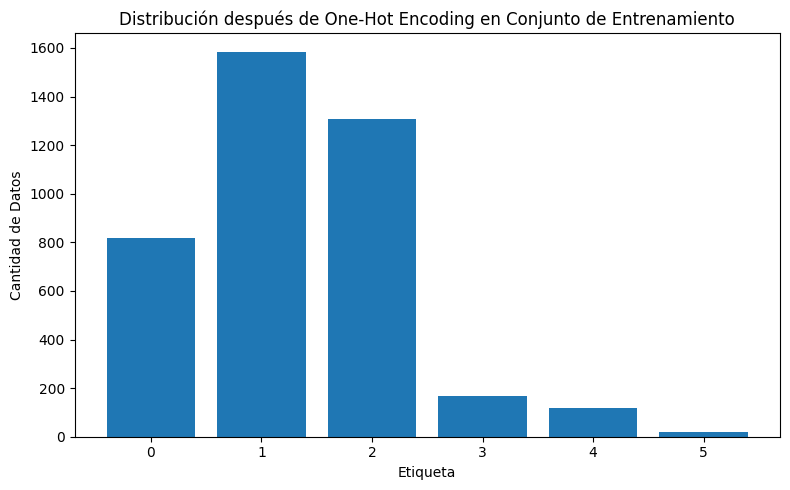

In [14]:
# Visualizar la distribución después de convertir las etiquetas a one-hot
plt.figure(figsize=(8, 5))
plt.bar(np.unique(y_train_one_hot.argmax(axis=1)), np.bincount(y_train_one_hot.argmax(axis=1)), align='center')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución después de One-Hot Encoding en Conjunto de Entrenamiento')
plt.tight_layout()
plt.show()

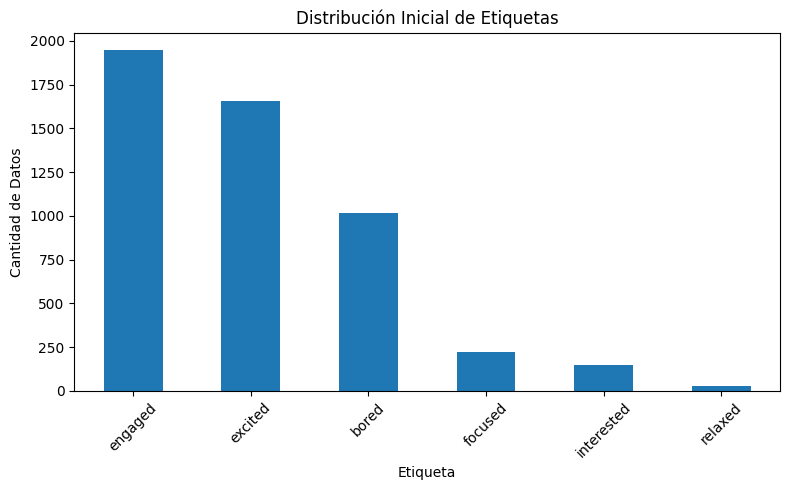

In [16]:
# Visualizar la distribución inicial de etiquetas
plt.figure(figsize=(8, 5))
df['Etiqueta'].value_counts().plot(kind='bar')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución Inicial de Etiquetas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Normalizamos los datos de entrenamiento y los de valores para verificar en numpy array

In [18]:
# Convertir las imágenes a arrays numpy y normalizarlas
X_train = np.array([np.array(img) for img in X_train])
X_val = np.array([np.array(img) for img in X_val])

Todos los datos de entrenamiento los ponemos en tipo flotante 32 y lo dividimos en 255 (que es formato de imagen), esto para normalizar del 0 al 1

In [19]:
# Normalizar las imágenes dividiendo por 255.0
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

Generamos infinidad de imagenes (Muchas imagenes. No son infinitas). Definimos los patrones para generar más imagenes y que el modelo no se sobre ajuste

In [20]:
# Definir el generador de imágenes para aumentar el dataset de entrenamiento
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



Aqui lo aumentamos.

In [21]:
# Aumentar el dataset de entrenamiento utilizando el generador de imágenes
train_generator = datagen.flow(X_train, y_train_one_hot, batch_size=28)


Todo el modelo definido

In [22]:
# Definir el modelo de red neuronal convolucional (CNN)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(etiquetas), activation='softmax')  # Capa de salida con activación softmax
])



/home/waldos/.local/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-14 21:03:23.224045: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 21:03:23.224451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

Compilamos el modelo.

In [23]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Entrenamos el modelo

In [24]:
# Definir Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [25]:
# Entrenar el modelo con el callback de TensorBoard
with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
                    epochs=40,
                    validation_data=(X_val, y_val_one_hot),
                    verbose=1,
                    callbacks=[early_stopping]
                    )


Epoch 1/40


/home/waldos/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715745808.546288   56307 service.cc:145] XLA service 0x7feaf00040f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715745808.546315   56307 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti with Max-Q Design, Compute Capability 7.5
2024-05-14 21:03:28.588095: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-14 21:03:28.737482: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 89

  5/144 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.3505 - loss: 1.6041

I0000 00:00:1715745812.183383   56307 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.3842 - loss: 1.3383 - val_accuracy: 0.4756 - val_loss: 1.1416
Epoch 2/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4663 - loss: 1.1500 - val_accuracy: 0.5095 - val_loss: 1.0676
Epoch 3/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5367 - loss: 1.0463 - val_accuracy: 0.5801 - val_loss: 0.9892
Epoch 4/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5775 - loss: 0.9794 - val_accuracy: 0.6249 - val_loss: 0.9192
Epoch 5/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5685 - loss: 0.9615 - val_accuracy: 0.6149 - val_loss: 0.9025
Epoch 6/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5815 - loss: 0.9218 - val_accuracy: 0.6209 - val_loss: 0.8698
Epoch 7/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6012 - loss: 0.9013 - val_accuracy: 0.6289 - val_loss: 0.8790
Epoch 8/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5877 - loss: 0.9022 - val_accuracy: 0.61

Guardamos el modelo

In [26]:
# Guardar el modelo
model.save('modelo_cnn_gray_NEstratificadoNew.h5')

Obtenemos predicciones del conjunto de validacion

In [27]:
# Obtener las predicciones del conjunto de validación
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Tabla graficamente de la precision y perdida del modelo a partir de las epocas

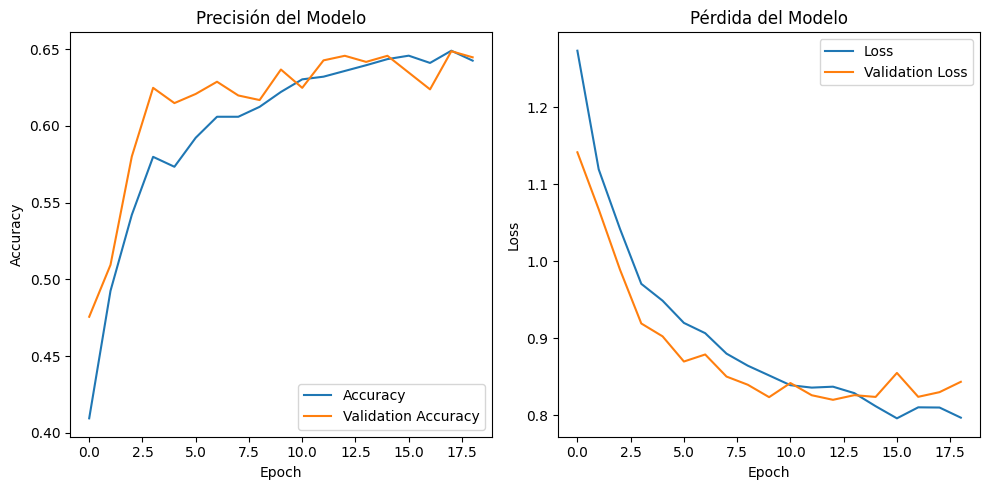

In [28]:
# Mostrar la precisión y pérdida del modelo
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Precisión del Modelo')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida del Modelo')

plt.tight_layout()
plt.show()

Matriz de confusion

In [29]:
# Calcular la matriz de confusión
conf_mat = confusion_matrix(np.argmax(y_val_one_hot, axis=1), y_pred_classes)

Visualizacion de la matriz de confusion mediante mapa de calor

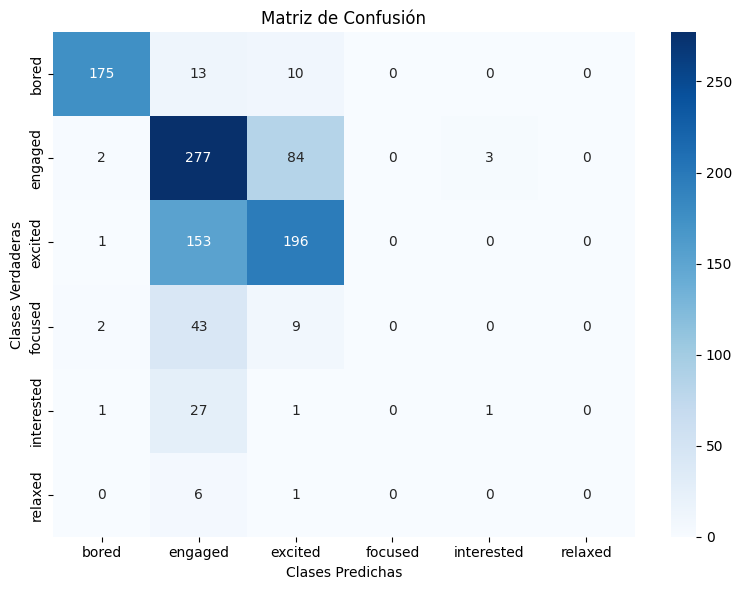

['bored', 'engaged', 'excited', 'focused', 'interested', 'relaxed']


In [30]:
# Visualizar la matriz de confusión como un mapa de calor
clases_originales = ['bored', 'engaged', 'excited' ,'focused', 'interested', 'relaxed']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=clases_originales, yticklabels=clases_originales)
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Verdaderas')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()
print(clases_originales)